# Database 

In [1]:
# Import functions and models
from functions import *
from models import *

# Set seed
set_seed(2020)

Using TensorFlow backend.


Firsly, the dataset is read using InferPy as it is included in the package.

In [2]:
# load the data
(X, y), _ = mnist.load_data(num_instances=1000, digits=[1,4,7])
# Create dataframe
dataset = pd.DataFrame(data=X)
dataset["number"] = y

Display the first 5 rows of the dataset.

In [3]:
dataset.head()

,0,1,2,3,4,5,6,7,8,9,...,775,776,777,778,779,780,781,782,783,number
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4


In [4]:
# Split dataframe
X = dataset.drop(['number'], axis=1)
y = dataset['number']

We print class balance.

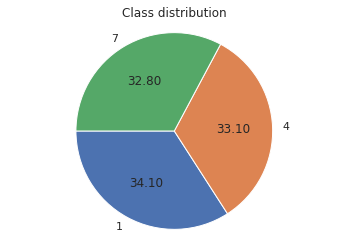

In [5]:
print_class_pie_diagram(y, ["1", "4", "7"])

# Constants

In [6]:
# Hidden space dimensionality
hidden_space_dim = 2
# Ammount of samples
n_samples = X.shape[0]
# Observed space dimensionality
observed_space_dim = X.shape[1]
# Ammount of classes
n_classes = len(y.unique())
# Hidden layer dimension for Non-linear PCA and VAE
hidden_layer_dim = 100
# Training epochs
num_epochs = 4000
# Learning rate for Adam optimizer
learning_rate = 0.01

# Reduction to 2-dimensional space

## Probabilistic PCA

The data is generated supposing both the hidden representation and the transformation is generated using standard Gaussian distributions:
$$
Z \sim \mathcal{N}_{hidden\_space\_dim}(0,I), \quad W \sim \mathcal{N}_{hidden\_space\_dim \times observed\_space\_dim}(0, I).
$$
$$
\delta \sim \mathcal{N}_{observed\_space\_dim}(0,I)
$$
The observed data follows a Gaussian distribution with parameters
$$
X \mid z, w, \delta \sim \mathcal{N}_{observed\_space\_dim}(w^T z + \delta, I).
$$

In [7]:
# create an instance of the P model and the Q model
pca_model = pca(hidden_space_dim, observed_space_dim)
pca_q = Q_pca(hidden_space_dim, observed_space_dim)

# Define optimizer 
optimizer = tf.train.AdamOptimizer(learning_rate)
# Define inference object
VI_pca = inf.inference.VI(pca_q, optimizer=optimizer, epochs=num_epochs)

We fit the model using the dataset ```X```.

In [8]:
pca_model.fit({"x": X}, VI_pca)        


 0 epochs	 2288882432.0....................
 200 epochs	 1999639168.0....................
 400 epochs	 1538645248.0....................
 600 epochs	 1372680960.0....................
 800 epochs	 1331959808.0....................
 1000 epochs	 1318128000.0....................
 1200 epochs	 1298531712.0....................
 1400 epochs	 1247384064.0....................
 1600 epochs	 1180991360.0....................
 1800 epochs	 1131365888.0....................
 2000 epochs	 1099915008.0....................
 2200 epochs	 1082905728.0....................
 2400 epochs	 1073884928.0....................
 2600 epochs	 1069038144.0....................
 2800 epochs	 1066316544.0....................
 3000 epochs	 1064712256.0....................
 3200 epochs	 1063792128.0....................
 3400 epochs	 1063162368.0....................
 3600 epochs	 1062474560.0....................
 3800 epochs	 1061843264.0....................

The evolution of the loss function over the training is:

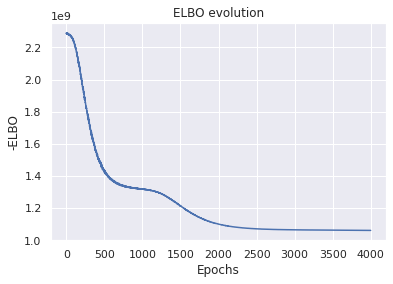

In [9]:
print_loss_function(VI_pca)

We plot the posterior using the learned model and the data.

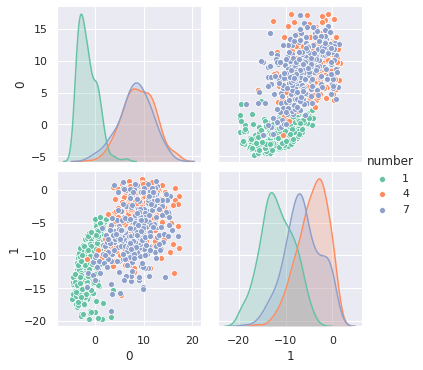

In [10]:
z = pca_model.posterior("z", data={"x": X}).sample()
print_posterior(z, y)

We can obtain the transformation by taking the posterior distribution of ```w```.

In [11]:
post = pca_model.posterior("w").parameters()
print("Loc:", post["loc"])
print("Scale:", post["scale"])

Loc: [[ 0.00946837 -0.0048061  -0.00576322 ... -0.01325872  0.00398508
   0.00216386]
 [-0.00421505  0.00625581  0.01035236 ...  0.00285118 -0.00199805
   0.0008871 ]]
Scale: [[0.01346306 0.01528796 0.01423914 ... 0.0154165  0.01450999 0.01458883]
 [0.01306768 0.01247543 0.01243964 ... 0.0137587  0.01237606 0.01284727]]


### Test Separability

We train an SVM to learn the dataset before and after applying the reduction, scores are shown below.

In [12]:
test_separability(X,z,y)

SVM score in observed space: 0.998
SVM score in hidden space: 0.737


## Non-linear PCA

The data is generated supposing the hidden representation is generated using standard Gaussian distributions:
$$
Z \sim \mathcal{N}_{hidden\_space\_dim}(0,I).
$$
A two layer network is used using standard Gaussian distribution for $\alpha_0, \alpha_1, \beta_0$ and $\beta_1$ as:
$$
f(z) = (relu(z^T \beta_0 + \alpha_0))^T\beta_1 + \alpha_1.
$$
The observed data follows a Gaussian distribution using $f$ for its mean value:
$$
X \mid z \sim \mathcal{N}_{observed\_space\_dim}(f(z), I).
$$

In [13]:
# create an instance of the P model and the Q model
nlpca_model = nlpca(hidden_space_dim, hidden_layer_dim, observed_space_dim)
nlpca_q = Q_nlpca(hidden_space_dim, hidden_layer_dim, observed_space_dim)

# Define optimizer 
optimizer = tf.train.AdamOptimizer(learning_rate)
# Define inference object
VI_nlpca = inf.inference.VI(nlpca_q, optimizer=optimizer, epochs=num_epochs)

Fit the model

In [14]:
nlpca_model.fit({"x": X}, VI_nlpca)        


 0 epochs	 2594014208.0....................
 200 epochs	 1560340352.0....................
 400 epochs	 1443729920.0....................
 600 epochs	 1430077952.0....................
 800 epochs	 1400047872.0....................
 1000 epochs	 1375457664.0....................
 1200 epochs	 1218173824.0....................
 1400 epochs	 1130064000.0....................
 1600 epochs	 1025563968.0....................
 1800 epochs	 968632256.0....................
 2000 epochs	 914201600.0....................
 2200 epochs	 883176064.0....................
 2400 epochs	 859963904.0....................
 2600 epochs	 842073856.0....................
 2800 epochs	 830602816.0....................
 3000 epochs	 819495360.0....................
 3200 epochs	 807270656.0....................
 3400 epochs	 793207040.0....................
 3600 epochs	 778217920.0....................
 3800 epochs	 761174080.0....................

Print loss function

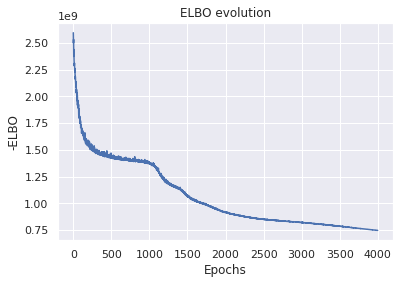

In [15]:
print_loss_function(VI_nlpca)

Print posterior sample.

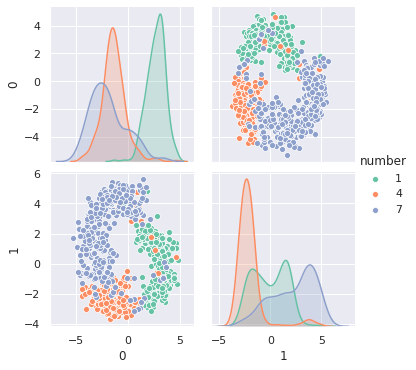

In [16]:
z = nlpca_model.posterior("z", data={"x": X}).sample()
print_posterior(z, y)

### Test Separability

In [17]:
test_separability(X,z,y)

SVM score in observed space: 0.998
SVM score in hidden space: 0.947


## Variational auto-encoder

The data is generated supposing the hidden representation is generated using standard Gaussian distributions:
$$
Z \sim \mathcal{N}_{hidden\_space\_dim}(0,I).
$$
A two layer network is used for the observed data's mean value:
$$
X \mid z \sim \mathcal{N}_{observed\_space\_dim}(f(z), I).
$$

On the other hand, the variational distribution supposes the observed representation is generated using standard Gaussian distributions:
$$
X \sim \mathcal{N}_{observed\_space\_dim}(0,I).
$$
A two layer network is used for the hidden data's mean value:
$$
Z \mid x \sim \mathcal{N}_{observed\_space\_dim}(g(z), I).
$$

In [18]:
vae_model = vae(hidden_space_dim, hidden_layer_dim, observed_space_dim)
q_vae = Q_vae(hidden_space_dim , hidden_layer_dim, observed_space_dim)

optimizer = tf.train.AdamOptimizer(learning_rate)
VI_vae = inf.inference.VI(q_vae, optimizer=optimizer, epochs=num_epochs)

Fit model

In [19]:
vae_model.fit({"x": X}, VI_vae)


 0 epochs	 2843358208.0....................
 200 epochs	 843643456.0....................
 400 epochs	 782928320.0....................
 600 epochs	 751631424.0....................
 800 epochs	 721475584.0....................
 1000 epochs	 710077120.0....................
 1200 epochs	 689969280.0....................
 1400 epochs	 678651584.0....................
 1600 epochs	 662125952.0....................
 1800 epochs	 651089856.0....................
 2000 epochs	 648332672.0....................
 2200 epochs	 642293696.0....................
 2400 epochs	 637110080.0....................
 2600 epochs	 623560384.0....................
 2800 epochs	 625858432.0....................
 3000 epochs	 623171776.0....................
 3200 epochs	 622912256.0....................
 3400 epochs	 612772544.0....................
 3600 epochs	 604231488.0....................
 3800 epochs	 604538688.0....................

Print loss function

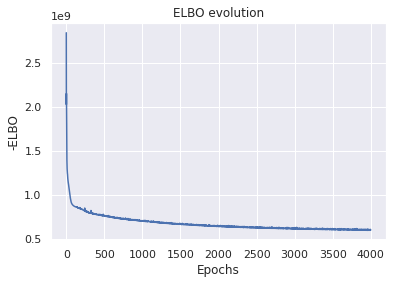

In [20]:
print_loss_function(VI_vae)

Print posterior sample 

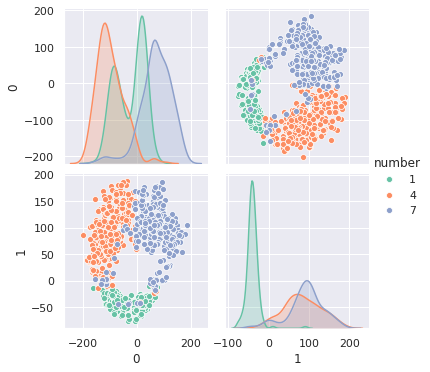

In [21]:
z = vae_model.posterior("z", data={"x": X}).sample()
print_posterior(z, y)

### Test Separability


In [22]:
test_separability(X,z,y)

SVM score in observed space: 0.998
SVM score in hidden space: 0.948


# Reduction to 3-dimensional space

We set the hidden space to be 3-dimensional.

In [23]:
hidden_space_dim = 3

## Probabilistic PCA

In [24]:
# create an instance of the P model and the Q model
pca_model = pca(hidden_space_dim, observed_space_dim)
pca_q = Q_pca(hidden_space_dim, observed_space_dim)

# Define optimizer 
optimizer = tf.train.AdamOptimizer(learning_rate)
# Define inference object
VI_pca = inf.inference.VI(pca_q, optimizer=optimizer, epochs=num_epochs)
# Training
pca_model.fit({"x": X}, VI_pca)        


 0 epochs	 2287730688.0....................
 200 epochs	 1906657024.0....................
 400 epochs	 1448066176.0....................
 600 epochs	 1345245312.0....................
 800 epochs	 1323136896.0....................
 1000 epochs	 1301236352.0....................
 1200 epochs	 1202217216.0....................
 1400 epochs	 1097742848.0....................
 1600 epochs	 1038932480.0....................
 1800 epochs	 994216320.0....................
 2000 epochs	 967198464.0....................
 2200 epochs	 952682880.0....................
 2400 epochs	 943174144.0....................
 2600 epochs	 936630656.0....................
 2800 epochs	 932122496.0....................
 3000 epochs	 929197824.0....................
 3200 epochs	 927290560.0....................
 3400 epochs	 925886336.0....................
 3600 epochs	 925013504.0....................
 3800 epochs	 924293824.0....................

Print posterior sample.

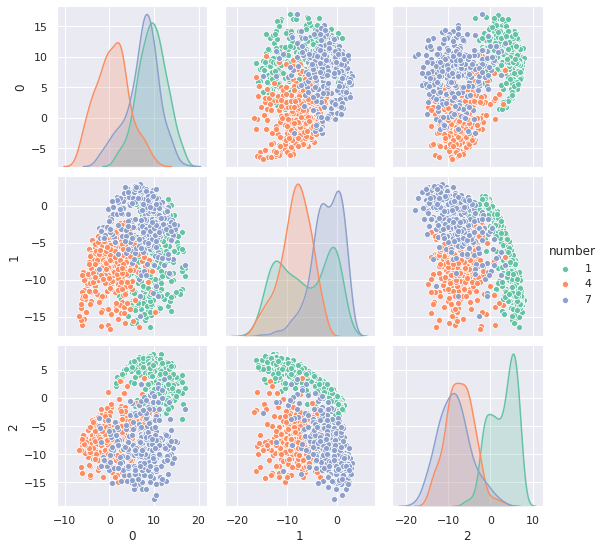

In [25]:
z = pca_model.posterior("z", data={"x": X}).sample()
print_posterior(z, y)

Test separability

In [26]:
test_separability(X,z,y)

SVM score in observed space: 0.998
SVM score in hidden space: 0.916


## Non-linear PCA

In [27]:
# create an instance of the P model and the Q model
nlpca_model = nlpca(hidden_space_dim, hidden_layer_dim, observed_space_dim)
nlpca_q = Q_nlpca(hidden_space_dim, hidden_layer_dim, observed_space_dim)

# Define optimizer 
optimizer = tf.train.AdamOptimizer(learning_rate)
# Define inference object
VI_nlpca = inf.inference.VI(nlpca_q, optimizer=optimizer, epochs=num_epochs)
# Training
nlpca_model.fit({"x": X}, VI_nlpca)


 0 epochs	 2645878016.0....................
 200 epochs	 1564205440.0....................
 400 epochs	 1457315968.0....................
 600 epochs	 1408474368.0....................
 800 epochs	 1398619904.0....................
 1000 epochs	 1330715776.0....................
 1200 epochs	 1169922304.0....................
 1400 epochs	 1109686144.0....................
 1600 epochs	 981257344.0....................
 1800 epochs	 883633472.0....................
 2000 epochs	 785723712.0....................
 2200 epochs	 726705728.0....................
 2400 epochs	 699891008.0....................
 2600 epochs	 680373504.0....................
 2800 epochs	 665791040.0....................
 3000 epochs	 652877824.0....................
 3200 epochs	 637100352.0....................
 3400 epochs	 620114368.0....................
 3600 epochs	 604040320.0....................
 3800 epochs	 589879488.0....................

Print posterior sample

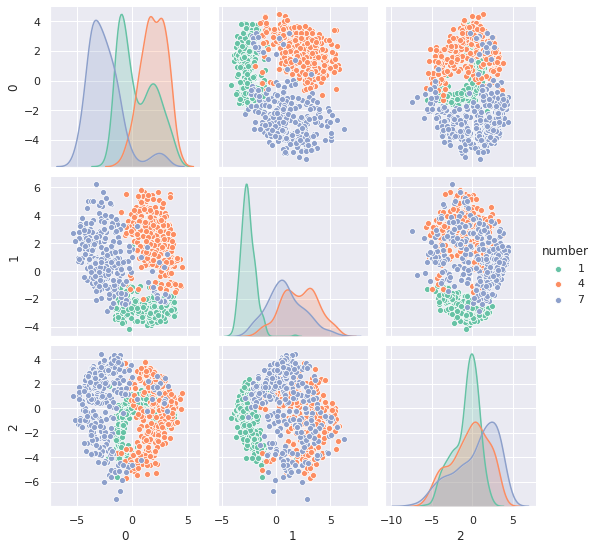

In [28]:
z = nlpca_model.posterior("z", data={"x": X}).sample()
print_posterior(z, y)

In [29]:
test_separability(X,z,y)

SVM score in observed space: 0.998
SVM score in hidden space: 0.969


## Variational auto-encoder

In [30]:
vae_model = vae(hidden_space_dim, hidden_layer_dim, observed_space_dim)
q_vae = Q_vae(hidden_space_dim , hidden_layer_dim, observed_space_dim)

optimizer = tf.train.AdamOptimizer(learning_rate)
VI_vae = inf.inference.VI(q_vae, optimizer=optimizer, epochs=num_epochs)
vae_model.fit({"x": X}, VI_vae)


 0 epochs	 2231706368.0....................
 200 epochs	 693352192.0....................
 400 epochs	 619567168.0....................
 600 epochs	 592053376.0....................
 800 epochs	 550355584.0....................
 1000 epochs	 535781920.0....................
 1200 epochs	 528884000.0....................
 1400 epochs	 511095840.0....................
 1600 epochs	 503785792.0....................
 1800 epochs	 487216128.0....................
 2000 epochs	 476108800.0....................
 2200 epochs	 474422144.0....................
 2400 epochs	 468769504.0....................
 2600 epochs	 460802368.0....................
 2800 epochs	 454710112.0....................
 3000 epochs	 451634336.0....................
 3200 epochs	 450936416.0....................
 3400 epochs	 442505248.0....................
 3600 epochs	 444116384.0....................
 3800 epochs	 442662656.0....................

Print posterior sample

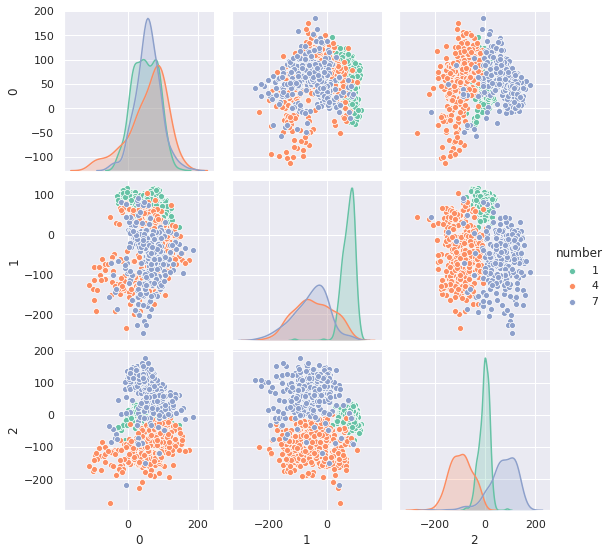

In [31]:
z = vae_model.posterior("z", data={"x": X}).sample()
print_posterior(z, y)

In [32]:
test_separability(X,z,y)

SVM score in observed space: 0.998
SVM score in hidden space: 0.965
